In [3]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
sys.path.insert(1, oj(sys.path[0], '../vision_fit'))  # insert parent path
import time
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch
from torch.autograd import Variable
import torchvision.models as models
import warnings
warnings.filterwarnings("ignore")
import data
from max_corr_cnns import get_model_pretrained, lays_and_names
import matplotlib.pyplot as plt
import seaborn as sns
import style

%load_ext autoreload
%autoreload 2

In [4]:
style.set_style()
import warnings
warnings.filterwarnings("ignore")

# look at stats

Model & Dim (out x in) & $||W||_F$ & Stable Rank & $\rho_{mem}$ \\
alexnet & 1000 x 4096 & 37.89 & 32.21 & 0.299 \\
vgg11 & 1000 x 4096 & 39.12 & 26.03 & 0.393 \\
vgg13 & 1000 x 4096 & 38.54 & 25.63 & 0.385 \\
vgg16 & 1000 x 4096 & 37.37 & 25.75 & 0.386 \\
vgg19 & 1000 x 4096 & 36.75 & 25.53 & 0.386 \\
resnet18 & 1000 x 512 & 49.7 & 34.6 & 0.556 \\
resnet34 & 1000 x 512 & 45.79 & 36.08 & 0.513 \\
resnet50 & 1000 x 2048 & 47.92 & 40.17 & 0.525 \\
resnet101 & 1000 x 2048 & 46.04 & 42.51 & 0.438 \\
resnet152 & 1000 x 2048 & 45.54 & 42.54 & 0.441 \\
densenet121 & 1000 x 1024 & 49.8 & 40.18 & 0.457 \\
densenet169 & 1000 x 1664 & 51.08 & 46.06 & 0.463 \\
densenet201 & 1000 x 1920 & 50.09 & 47.07 & 0.44 \\


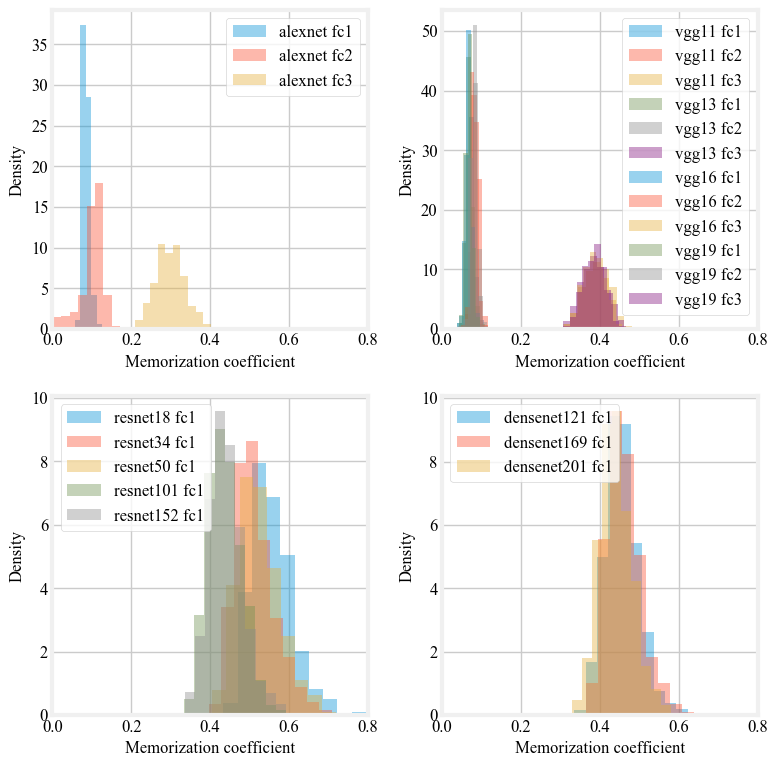

In [5]:
max_corr_dir = '/accounts/projects/vision/scratch/yu_dl/raaz.rsk/max_corrs'
fnames = os.listdir(max_corr_dir)
corrs = {}
R, C = 2, 2
print_fc1 = True
model_names_list = [['alexnet', 'inception_v3'],
               ['vgg11', 'vgg13', 'vgg16', 'vgg19'],
#                ['vgg16'],
               ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152'],                    
               ['densenet121', 'densenet169', 'densenet201']]

plt.figure(figsize=(8, 8), dpi=100)
if print_fc1:
    print('Model & Dim (out x in) & $||W||_F$ & Stable Rank & $\\rho_{mem}$ \\\\')
else:
    print('Model & Layer & Dim (out x in) & $||W||_F$ & Stable Rank & $\\rho_{mem}$ \\\\')
for i, model_names in enumerate(model_names_list):
    plt.subplot(R, C, i + 1)
    for model_name in model_names:
        fnames_m = [fname for fname in fnames if model_name in fname and not '_0' in fname]
            
        if len(fnames_m) == 1:
            max_corrs = pkl.load(open(oj('max_corrs', fnames_m[0]), "rb"))
            model = get_model_pretrained(model_name)
            lays, lay_names = lays_and_names(model, model_name)
            num_lays = str(len(lays))
            for lay, lay_name in zip(lays, lay_names):
                max_corr = max_corrs[lay_name]
                w = lay.weight            
                max_corr_norm = max_corr / w.norm(dim=1)
                svs = w.svd(compute_uv=False)[1].detach().cpu().numpy()**2
                if print_fc1 and lay_name == 'fc' + num_lays: 
                    print(model_name, '&', w.shape[0], 'x', w.shape[1],
                      '&', round(w.norm().item(), 2), '&', round(np.sum(svs) / np.max(svs), 2),
                      '&', round(max_corr.mean().item(), 3), '\\\\')
                elif not print_fc1 and not lay_name == 'fc' + num_lays:
                    print(model_name, '&', lay_name, '&', w.shape[0], 'x', w.shape[1],
                      '&', round(w.norm().item(), 2), '&', round(np.sum(svs) / np.max(svs), 2),
                      '&', round(max_corr.mean().item(), 3), '\\\\')
                   
                corrs[model_name] = max_corr.cpu().numpy()
                plt.hist(max_corr.cpu().numpy(), label=model_name + ' ' + lay_name, density=True, alpha=0.4)
        elif len(fnames_m) >= 1:
            print('delete older iters!')
        else:
            pass
    plt.xlim((0, 0.8))
    plt.legend()
    plt.xlabel('Memorization coefficient')
    plt.ylabel('Density')
plt.tight_layout()
plt.savefig('corr_hists.pdf')
plt.show()

# compare max corr by class

In [6]:
fnames = os.listdir(max_corr_dir)
corrs = {}

model_names = ['alexnet', 'vgg11', 'vgg13', 'vgg16', 'vgg19', 
               'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152',
               'densenet121', 'densenet169', 'densenet201']
ms, ws = [], []
fnames = os.listdir('./max_corrs')
for model_name in tqdm(model_names):
    fnames_m = [fname for fname in fnames if model_name in fname]
    if len(fnames_m) == 1:
        max_corrs = pkl.load(open(oj('max_corrs', fnames_m[0]), "rb"))
        model = get_model_pretrained(model_name)
        lays, lay_names = lays_and_names(model, model_name)

        # look at last fc
        lay = lays[-1]
        lay_name = lay_names[-1]
        
        w = lay.weight            
        max_corr = max_corrs[lay_name]
        max_corr_norm = max_corr / w.norm(dim=1)
        
        w = w.cpu().detach().numpy()
        ws.append(w)        
        ms.append(max_corr_norm.cpu().detach().numpy())
    elif len(fnames_m) >= 1:
        print('delete older iters!')
    else:
        pass

len(ws)
wf = np.array([w.flatten() for w in ws])
mf = np.array([m.flatten() for m in ms])
print(wf.shape, mf.shape)

100%|██████████| 13/13 [00:20<00:00,  1.51s/it]

(13,) (13, 1000)


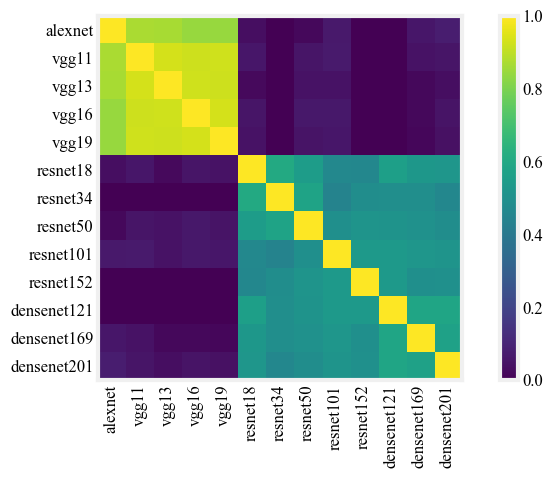

In [7]:
plt.figure(figsize=(8, 5), dpi=100)
# plt.imshow(mf[:, :20])
plt.imshow(np.corrcoef(mf), vmin=0, vmax=1, interpolation=None)

# sns.heatmap(np.corrcoef(mf), annot=True)
plt.xticks(range(len(model_names)), model_names, rotation='vertical')
plt.yticks(range(len(model_names)), model_names, rotation='horizontal')
plt.colorbar()
plt.grid(False)

plt.tight_layout()
plt.savefig('cnn_classes.pdf')

# load in imagenet dset

In [32]:
class p: pass
p.batch_size = 100
p.dset = 'imagenet'
train_loader, val_loader = data.get_data_loaders(p)

loading imagenet train dset...
done loading train dset 12.968705 sec


In [35]:
# calculate max corrs for a linear layer
def linear_hook(module, act_in, act_out):
    # b is batch_size
    # input is (b x in_size)
    # weight is (out_size x in_size)
    # output is (out_1, ...., out_b)
    print(module.name)
    act_in_norm = act_in[0].t() / torch.norm(act_in[0], dim=1) # normalize each of b rows
    act_in_norm = act_in_norm.t() # transpose back to b x in_size
    
    Y = torch.matmul(act_in_norm, module.weight.t()) # Y is (b x out_size)
    
    corrs = torch.max(Y, dim=0)[0] # b (1-d)
    
    if not module.name in max_corrs:
        max_corrs[module.name] = corrs
    else:
        max_corrs[module.name] = torch.max(corrs, max_corrs[module.name]) # element wise max
    print('hook', module.name)


In [50]:
# run - training set is about 14 mil
for i, x in enumerate(val_loader):
    ims = x[0].cuda()
    break

In [58]:
model_name = 'densenet121' # alexnet, vgg16, inception_v3, resnet18, densenet
model = get_model_pretrained(model_name)
lays, names = lays_and_names(model, model_name)
print(lays)
for i, lay in enumerate(lays):
    lay.name = names[i]
    lay.register_forward_hook(linear_hook)
                              
max_corrs = {}   

# model.classifier[1].register_forward_hook(linear_hook)

[Linear(in_features=1024, out_features=1000, bias=True)]


In [ ]:
_ = model(ims)